# WOA13 cross sections

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import iris
iris.FUTURE.netcdf_promote = True


def woa_subset(url, bbox=[-179.875, -89.875, 179.875, 89.875], level=None):
    cubes = iris.load_raw(url)
    # TODO: Getting only the OA field for now.
    for idx, cube in enumerate(cubes):
        if 'Objectively analyzed mean fields for' in cube.long_name:
            cube = cubes.pop(idx)
            break

    # Select data subset.
    lon = iris.Constraint(longitude=lambda lon: bbox[0] <= lon <= bbox[2])
    lat = iris.Constraint(latitude=lambda lat: bbox[1] <= lat <= bbox[3])
    if level:
        dep = iris.Constraint(depth=lambda z: z == level)
        cube = cube.extract(lon & lat & dep)
    else:
        cube = cube.extract(lon & lat)

    if cube.ndim >= 3 and cube.shape[0] == 1:  # Squeeze time dimension.
        cube = cube[0, ...]
    return cube

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree(), resolution='110m'):
    fig, ax = plt.subplots(figsize=(11, 7),
                           subplot_kw=dict(projection=projection))
    ax.set_global()
    ax.coastlines(resolution=resolution, color='k')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND, facecolor='0.75')
    return fig, ax

In [4]:
ocean = dict(
    Indian=dict(
        bbox=[45., -32., 105., -32.]
    )
)

level = None
ocean = ocean['Indian']

base = 'https://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA/'
var = dict(
    temp='temperature/netcdf/decav/0.25/woa13_decav_t00_04.nc',
    sal='salinity/netcdf/decav/0.25/woa13_decav_s00_04.nc',
    nit='nitrate/netcdf/all/1.00/woa13_all_n00_01.nc',
    aou='AOU/netcdf/all/1.00/woa13_all_A00_01.nc',
    oxy='oxygen/netcdf/all/1.00/woa13_all_o00_01.nc',
    sil='silicate/netcdf/all/1.00/woa13_all_i00_01.nc',
    phos='phosphate/netcdf/all/1.00/woa13_all_p00_01.nc'
)

temp
sal
nit
aou
oxy
sil
phos


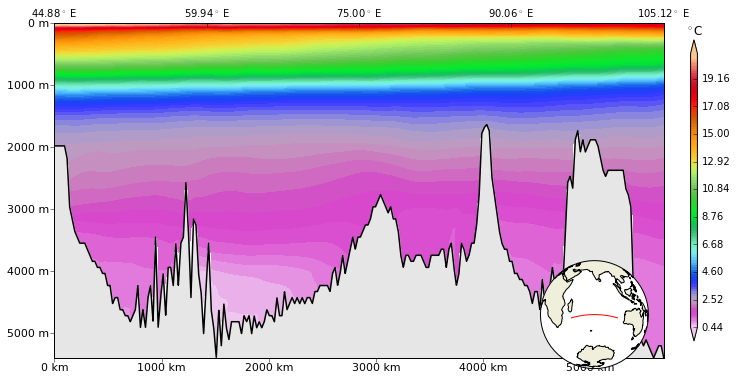

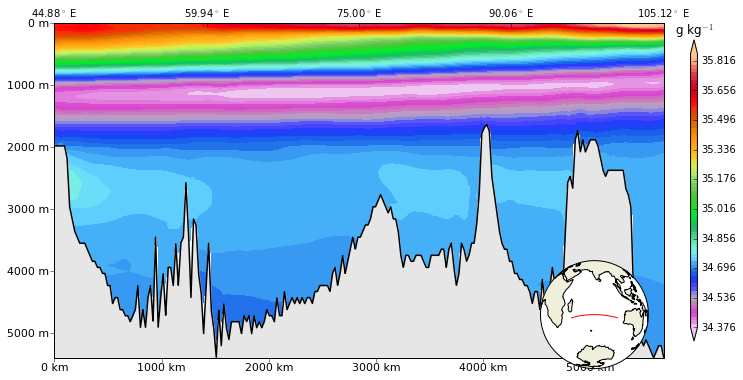

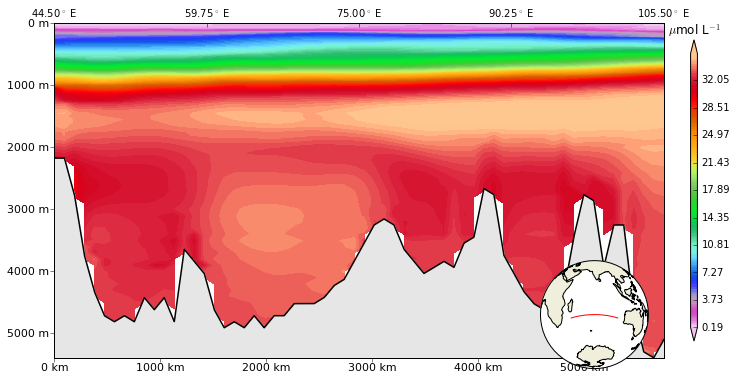

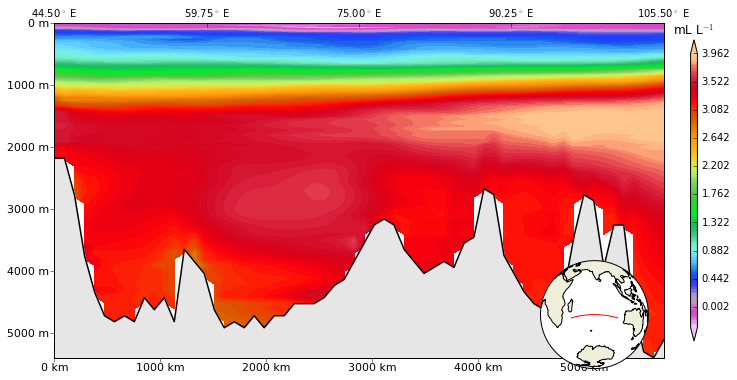

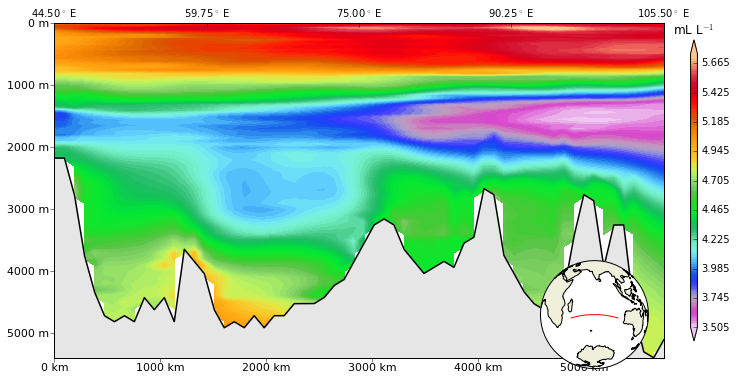

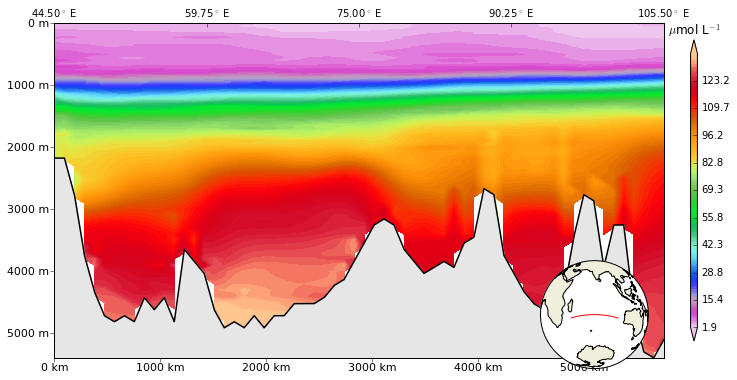

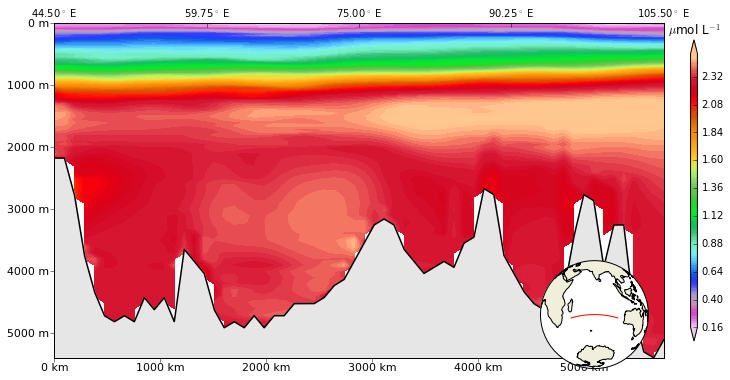

In [5]:
%matplotlib inline

import numpy as np

from ctd import plot_section
from oceans.colormaps import cm
from matplotlib.ticker import FuncFormatter
from iris.pandas import as_data_frame


for key, value in var.items():
    print(key)
    url = base + value
    fname = value.split('/')[-1]
    cube = woa_subset(url, bbox=ocean['bbox'], level=level)
    if cube.ndim > 2:
        cube = cube.collapsed(['latitude'], iris.analysis.MEAN)

    if key == 'temp':
        title = 'Temperature'
        units = r'$^\circ$C'
        cmap = cm.avhrr
    elif key == 'sal':
        title = 'Salinity'
        units = r'g kg$^{-1}$'
        cmap = cm.odv
    elif key == 'nit':
        title = 'Nitrogen'
        units = r'$\mu$mol L$^{-1}$'
        cmap = cm.odv
    elif key == 'aou' or key == 'oxy':
        title = 'AOU'
        units = r'mL L$^{-1}$'
        cmap = cm.odv
    elif key == 'sil':
        title = 'Silicate'
        units = r'$\mu$mol L$^{-1}$'
        cmap = cm.odv
    elif key == 'phos':
        title = 'Phosphate'
        units = r'$\mu$mol L$^{-1}$'
        cmap = cm.odv

    lon = cube.coord(axis='X').points
    lat = cube.coord(axis='Y').points

    df = as_data_frame(cube)
    if key == 'sal':
        df = df.clip(33, 37)  # 27.5, 37.5
    levels = np.arange(df.min().min(), df.max().max(), 0.02)
    df.lon = lon
    df.lat = np.repeat(lat, len(lon))

    fig, ax, cbar = plot_section(df, cmap=cm.odv, marker=None,
                                 levels=levels)
    cbar.ax.set_title(units)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add km to x-axis.
    def km(x, pos):
        if x.is_integer():
            x = int(x)
        return '{} km'.format(x)
    km_formatter = FuncFormatter(km)
    ax.xaxis.set_major_formatter(km_formatter)

    # Add m to y-axis.
    def m(x, pos):
        if x.is_integer():
            x = int(x)
        return '{} m'.format(x)
    m_formatter = FuncFormatter(m)
    ax.yaxis.set_major_formatter(m_formatter)

    # New x-axis.
    def deg(labels):
        new_labels = []
        for x in labels:
            if x < 0:
                text = r'%.2f$^\circ$ W' % abs(x)
            elif x > 0:
                text = r'%.2f$^\circ$ E' % x
            else:
                text = r'%.2f$^\circ$' % x
            new_labels.append(text)
        return new_labels

    ax2 = ax.twiny()
    xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[-1]
    loc = np.array([xmin, xmax*0.25, xmax*0.5, xmax*0.75, xmax])
    labels = [np.percentile(lon, 0), np.percentile(lon, 25),
              np.percentile(lon, 50), np.percentile(lon, 75),
              np.percentile(lon, 100)]
    ax2.set_xticks(loc)
    ax2.set_xticklabels(deg(labels))

    # Global inset map.
    projection = ccrs.Orthographic(central_longitude=lon.mean(),
                                   central_latitude=lat.mean())
    axin = plt.axes([0.625, 0.1, 0.25, 0.25], projection=projection)
    axin.set_global()
    axin.add_feature(cfeature.LAND)
    axin.coastlines()
    axin.plot(df.lon, df.lat, 'r', transform=ccrs.Geodetic())